# Introduction
Lab notebooks are, in order:
1. exploration.ipynb: EDA
2. pima-model-lab-notebook.ipynb: initial model building on Pima Indians Diabetes dataset
3. pima-fram-lab-notebook.ipynb: attempting to improve model by adding Framingham Heart Study data

The big problem was that that two datasets were different not just in diabetes prevalance but also in shape of other features, resulting in a model which was performing as well as others in the scores but not making sense from a biology perspective. Age should not be negatively correlated with type II diabetes risk unless you're looking only at women who have had children and so much of what you're seeing is gestational diabetes, which will likely be a nonlinear relationship with a hump of diabetes in the 20-40 range.

This notebook is a streamlined version of building a set of models for the streamlit app.

# Methods
## Data import

In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import matplotlib as plt
import seaborn as sbn
import numpy as np
import psycopg2 as pg

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score


In [2]:
connection_args = {'host': 'localhost', 
                   'dbname': 'med_data', 
                   'port': 5432}
connection = pg.connect(**connection_args)

query = """SELECT * FROM pima"""
with open('tempfile.csv', 'wb') as tmpfile:
    copy_sql = "COPY ({query}) TO STDOUT WITH CSV {head}".format(
       query=query, head="HEADER"
    )
    cursor = connection.cursor()
    cursor.copy_expert(copy_sql, tmpfile)
    tmpfile.seek(0)

    pima_data = pd.read_csv('tempfile.csv')

In [3]:
outcome_series = pima_data['outcome'] == 't'
diabetes_series = pima_data['diabetes'] == 't'
pima_data['outcome'] = outcome_series
pima_data['diabetes'] = diabetes_series

In [5]:
pima_data[['glucose', 'diabp', 'skinthickness', 'insulin']] = pima_data[['glucose', 'diabp', 'skinthickness', 'insulin']].replace(0, np.nan)

## Using subset of pima data to get best model parameters
For the sake of consistency and minimizing user confusion, I want to use the same train-test split for all four data sets. I'm doing this before the dropna() so that I can preserve as much data as possible, but the hope is that this will result in four models where the feature set really is the biggest difference between them.

In [19]:
# Split consistently on all the sets
from sklearn.model_selection import ShuffleSplit
shuffle = ShuffleSplit(n_splits = 1, random_state = 54, test_size = 0.2)
train_indices = []
test_indices = []
for train_index, test_index in shuffle.split(pima_data):
    train_indices = list(train_index)
    test_indices= list(test_index)

In [21]:
train_ab = pima_data.loc[train_indices, ['age', 'bmi', 'diabetes']]
train_ab.dropna()
test_ab = pima_data.loc[test_indices, ['age', 'bmi', 'diabetes']]
test_ab.dropna()

train_abd = pima_data.loc[train_indices, ['age', 'bmi', 'diabp', 'diabetes']]
train_abd.dropna()
test_abd = pima_data.loc[test_indices, ['age', 'bmi', 'diabp', 'diabetes']]
test_abd.dropna()

train_abp = pima_data.loc[train_indices, ['age', 'bmi', 'pregnancies', 'diabetes']]
train_abp.dropna()
test_abp = pima_data.loc[test_indices, ['age', 'bmi', 'pregnancies', 'diabetes']]
test_abp.dropna()

train_abdp = pima_data.loc[train_indices, ['age', 'bmi', 'diabp', 'pregnancies', 'diabetes']]
train_abdp.dropna()
test_abdp = pima_data.loc[test_indices, ['age', 'bmi', 'diabp', 'pregnancies', 'diabetes']]
test_abdp.dropna()

,age,bmi,diabp,pregnancies,diabetes
18,33,43.3,30.0,1,False
467,25,36.8,64.0,0,False
87,26,38.5,68.0,2,False
659,27,34.2,82.0,3,True
208,21,33.2,64.0,1,False
...,...,...,...,...,...
230,22,44.0,86.0,4,True
318,28,38.1,66.0,3,False
551,25,31.9,68.0,3,False
756,39,32.0,90.0,7,False


In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'class_weight': ['balanced', None], 'solver': ['liblinear', 'lbfgs', 'newton-cg']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='balanced_accuracy', verbose=0)

In [85]:
param_grid = {'C': [0.1, 1, 10, 100], 
              'class_weight': ['balanced', None], 
             'solver': ['lbfgs', 'liblinear', 'newton-cg']}
gscv = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid, scoring = 'balanced_accuracy', cv = 4, return_train_score = True)
gscv.fit(train_ab[['age', 'bmi']], train_ab['diabetes'])
gscv.best_params_

{'C': 1, 'class_weight': 'balanced', 'solver': 'liblinear'}

In [77]:
gscv.best_estimator_.coef_

array([[0.04670707, 0.06963381]])

In [78]:
gscv.fit(train_abd[['age', 'bmi', 'diabp']], train_abd['diabetes'])
gscv.best_params_

{'C': 1, 'class_weight': 'balanced', 'solver': 'liblinear'}

In [79]:
gscv.best_estimator_.coef_

array([[ 0.04932413,  0.06940796, -0.00104953]])

In [80]:
gscv.fit(train_abp[['age', 'bmi', 'pregnancies']], train_abp['diabetes'])
gscv.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}

In [73]:
gscv.best_estimator_.coef_

array([[0.04361281, 0.09051201, 0.07484378]])

In [81]:
gscv.fit(train_abdp[['age', 'bmi', 'diabp', 'pregnancies']], train_abdp['diabetes'])
gscv.best_params_

{'C': 10, 'class_weight': 'balanced', 'solver': 'liblinear'}

In [83]:
gscv.best_estimator_.coef_

array([[0.04202822, 0.08520294, 0.00875516, 0.07410018]])

### On balance, let's go with 1.0, 'balanced', and 'liblinear'
Given how few features there are, less regularization is likely to be necessary.

'class_weight' is the parameter to tune in order to get the balance I want between false negatives and false positives. Given the relative costs of diabetes screening and a year of diabetes care, I'm aiming for around 1 false negative for every 50-100 false positives. If I were truly pitching this to an insurance company, I would want to take the time to make a slider or a dropdown that allows the client to select the desired number of false positives per false negative within an approximately 25-200 range; outside of either extreme seems intuitively unfair to either the people who miss being diagnosed or the people who get stuck with an unnecessary blood test.

Liblinear takes either l1 or l2 penalties, and while I could figure out which penalty works best, I'm choosing not to. This decision is due in large part to the fact that I don't care to do all the setup necessary for creating my own grid search function that fits a scaler to each training fold. Also, the default penalty of 'l2' is the one that I tend to lean towards for smaller feature sets in any case, as it spreads the coefficients around rather than pushing small ones towards zero. This model isn't going to have the greatest scores in any case, and the benefit of deciding between the two regularization penalties is unlikely to be significant to anything for a prototype project.

### Finding best class_weight to balance false negatives and false positives

In [99]:
from sklearn.metrics import confusion_matrix

weights_list = [{True: 8, False: 1}, {True: 8.5, False: 1}, {True: 9, False: 1}, 
               {True: 9.5, False: 1}, {True: 10, False: 1}, 
               {True: 10.5, False: 1}, {True: 11, False: 1}, {True: 11.5, False: 1}]
# Putting together a list of dicts that I can then put into a dataframe
weights_results = []
# iterate through the class_weight options
for i in weights_list:
    lr = LogisticRegressionCV(penalty = 'l2', scoring = 'recall', solver = 'liblinear', 
                              class_weight = i)
    lr.fit(train_ab[['age', 'bmi']], train_ab['diabetes'])
    # Essentially using this to get the scores and confusion matrix for the cross-validated model
    lr_pred = lr.predict(train_ab[['age', 'bmi']])
    lr_conf = confusion_matrix(train_ab['diabetes'], lr_pred)
    weights_results.append({'weight': i[True], 
                           'coefficients': lr.coef_, 
                           'recall': recall_score(train_ab['diabetes'], lr_pred), 
                           'false negatives': lr_conf[1][0], 
                           'false positives': lr_conf[0][1]})
results_df = pd.DataFrame(weights_results)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv'

In [100]:
results_df

,weight,coefficients,recall,false negatives,false positives
0,8.0,"[[0.029297746471932642, 0.027076031692056225]]",1.0,0,342
1,8.5,"[[0.029968144348868304, 0.02811564209481826]]",1.0,0,342
2,9.0,"[[0.030648923563846842, 0.029047801998230083]]",1.0,0,342
3,9.5,"[[0.03127237811548386, 0.02995292763066094]]",1.0,0,342
4,10.0,"[[0.03186592911579925, 0.030811455619459707]]",1.0,0,342
5,10.5,"[[0.032432539447684684, 0.03162782205952117]]",1.0,0,342
6,11.0,"[[0.03297475214946724, 0.032405845468103454]]",1.0,0,342
7,11.5,"[[0.03349476513811141, 0.03314883694270513]]",1.0,0,342


In [110]:
weights_list = [{True: 1, False: 1}, {True: 2, False: 1}, {True: 3, False: 1}, 
               {True: 4, False: 1}, {True: 5, False: 1}, 
               {True: 6, False: 1}, {True: 7, False: 1}, {True: 8, False: 1}]
# Putting together a list of dicts that I can then put into a dataframe
weights_results = []
# iterate through the class_weight options
for i in weights_list:
    lr = LogisticRegressionCV(penalty = 'l2', scoring = 'recall_weighted', solver = 'liblinear', 
                              class_weight = i)
    lr.fit(train_ab[['age', 'bmi']], train_ab['diabetes'])
    # Essentially using this to get the scores and confusion matrix for the cross-validated model
    lr_pred = lr.predict(train_ab[['age', 'bmi']])
    lr_conf = confusion_matrix(train_ab['diabetes'], lr_pred)
    weights_results.append({'weight': i[True], 
                           'coefficients': lr.coef_, 
                           'recall': recall_score(train_ab['diabetes'], lr_pred), 
                           'false negatives': lr_conf[1][0], 
                           'false positives': lr_conf[0][1]})
results_df = pd.DataFrame(weights_results)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv'

In [111]:
results_df

,weight,coefficients,recall,false negatives,false positives
0,1,"[[0.03695880184799391, 0.0486686769749013]]",0.547794,123,75
1,2,"[[0.05756389557202192, 0.08954170895572236]]",0.830882,46,173
2,3,"[[0.059568192552723956, 0.08858485011423597]]",0.941176,16,225
3,4,"[[0.06132124705303733, 0.08844616240157792]]",0.959559,11,267
4,5,"[[0.062366302921968014, 0.08762751967234779]]",0.977941,6,290
5,6,"[[0.06300577815174549, 0.08657797761040381]]",0.996324,1,315
6,7,"[[0.06352415364010106, 0.08563950681976078]]",0.996324,1,328
7,8,"[[0.06430213268458723, 0.08547591856246615]]",0.996324,1,333


In [114]:
weights_list = [{True: 2.1, False: 1}, {True: 2.2, False: 1}, {True: 2.3, False: 1}, 
               {True: 2.4, False: 1}, {True: 2.5, False: 1}, {True: 2.6, False: 1}, 
               {True: 2.7, False: 1}, {True: 2.8, False: 1}, {True: 2.9, False: 1}]
# Putting together a list of dicts that I can then put into a dataframe
weights_results = []
# iterate through the class_weight options
for i in weights_list:
    lr = LogisticRegressionCV(penalty = 'l2', scoring = 'recall_weighted', solver = 'liblinear', 
                              class_weight = i)
    lr.fit(train_ab[['age', 'bmi']], train_ab['diabetes'])
    # Essentially using this to get the scores and confusion matrix for the cross-validated model
    lr_pred = lr.predict(train_ab[['age', 'bmi']])
    lr_conf = confusion_matrix(train_ab['diabetes'], lr_pred)
    weights_results.append({'weight': i[True], 
                           'coefficients': lr.coef_, 
                           'recall': recall_score(train_ab['diabetes'], lr_pred), 
                           'false negatives': lr_conf[1][0], 
                           'false positives': lr_conf[0][1]})
results_df = pd.DataFrame(weights_results)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv'

In [115]:
results_df

,weight,coefficients,recall,false negatives,false positives
0,2.1,"[[0.05771430690364213, 0.08922862043143796]]",0.845588,42,179
1,2.2,"[[0.05793394313241683, 0.08910492750176296]]",0.871324,35,185
2,2.3,"[[0.058213971725538105, 0.08914268481399336]]",0.893382,29,189
3,2.4,"[[0.058601174501105864, 0.0894424318101029]]",0.893382,29,194
4,2.5,"[[0.05855912094327467, 0.08880114107726125]]",0.911765,24,199
5,2.6,"[[0.05853453352910391, 0.08822991914652291]]",0.922794,21,207
6,2.7,"[[0.05898878474861522, 0.0887251571020589]]",0.926471,20,211
7,2.8,"[[0.05919241311218243, 0.08868672083710233]]",0.930147,19,217
8,2.9,"[[0.059689866402832026, 0.08929930256347184]]",0.937500,17,219


### Final model parameters found; now to generate using the whole Pima dataset
Initially, these weight tests were run using only recall, which resulted in an understandably strong bias towards false positives. Using weighted recall, a more reasonable false positive to false negative ratio could be found without tuning the class weights down to past the tenths.

Will be using LogisticRegression with penalty = 'l2', C = 0.1, class_weight = {True: 2.6, False: 1}, solver = 'liblinear' for all four models.

## Generating final models
### Age and bmi only model

In [129]:
import pickle

model_ab = LogisticRegression(penalty = 'l2', C = 1.0, class_weight = {True: 2.6, False: 1}, 
                              solver = 'liblinear')
ab_data = pima_data[['age', 'bmi', 'diabetes']].dropna()
model_ab.fit(ab_data[['age', 'bmi']], ab_data['diabetes'])
with open('ab_logreg.pkl', 'wb') as fp:
    pickle.dump(model_ab, fp)
model_ab.coef_

array([[0.05273564, 0.08703538]])

In [117]:
model_abd = LogisticRegression(penalty = 'l2', C = 1.0, class_weight = {True: 2.6, False: 1}, 
                              solver = 'liblinear')
abd_data = pima_data[['age', 'bmi', 'diabp', 'diabetes']].dropna()
model_abd.fit(abd_data[['age', 'bmi', 'diabp']], abd_data['diabetes'])
with open('abd_logreg.pkl', 'wb') as fp:
    pickle.dump(model_abd, fp)
model_abd.coef_

array([[0.05391884, 0.08675281, 0.001567  ]])

In [118]:
model_abp = LogisticRegression(penalty = 'l2', C = 1.0, class_weight = {True: 2.6, False: 1}, 
                              solver = 'liblinear')
abp_data = pima_data[['age', 'bmi', 'pregnancies', 'diabetes']].dropna()
model_abp.fit(abp_data[['age', 'bmi', 'pregnancies']], abp_data['diabetes'])
with open('abp_logreg.pkl', 'wb') as fp:
    pickle.dump(model_abp, fp)
model_abp.coef_

array([[0.04082995, 0.08846132, 0.07420784]])

In [119]:
model_abdp = LogisticRegression(penalty = 'l2', C = 1.0, class_weight = {True: 2.6, False: 1}, 
                              solver = 'liblinear')
abdp_data = pima_data[['age', 'bmi', 'diabp', 'pregnancies', 'diabetes']].dropna()
model_abdp.fit(abdp_data[['age', 'bmi', 'diabp', 'pregnancies']], abdp_data['diabetes'])
with open('abdp_logreg.pkl', 'wb') as fp:
    pickle.dump(model_abdp, fp)
model_abdp.coef_

array([[0.04334931, 0.08927498, 0.00190589, 0.06907516]])

# Results
How do these models fare against the Framingham Heart Study participants? In the pima-fram-lab-notebook.ipynb, the model trained on only the Pima data did OK on the Framingham Heart Study data.

In [120]:
query = """SELECT * FROM fram"""
with open('tempfile.csv', 'wb') as tmpfile:
    copy_sql = "COPY ({query}) TO STDOUT WITH CSV {head}".format(
       query=query, head="HEADER"
    )
    cursor = connection.cursor()
    cursor.copy_expert(copy_sql, tmpfile)
    tmpfile.seek(0)

    fram_data = pd.read_csv('tempfile.csv')
# Calling all people with diabetes OR prediabetes as diabetic
diabetes_series = fram_data['glucose'] >=140
diabetes_series = diabetes_series | fram_data['diabetes'] == 1
fram_data['diabetes'] = diabetes_series

In [121]:
fram_data.head()

,male,age,education,currentsmoker,cigsperday,bpmeds,prevalentstroke,prevalenthyp,diabetes,totchol,sysbp,diabp,bmi,heartrate,glucose,tenyearchd
0,t,39,4.0,f,0.0,0.0,0,0,False,195.0,106.0,70.0,26.97,80.0,77.0,f
1,f,46,2.0,f,0.0,0.0,0,0,False,250.0,121.0,81.0,28.73,95.0,76.0,f
2,t,48,1.0,t,20.0,0.0,0,0,False,245.0,127.5,80.0,25.34,75.0,70.0,f
3,f,61,3.0,t,30.0,0.0,0,1,False,225.0,150.0,95.0,28.58,65.0,103.0,t
4,f,46,3.0,t,23.0,0.0,0,0,False,285.0,130.0,84.0,23.10,85.0,85.0,f


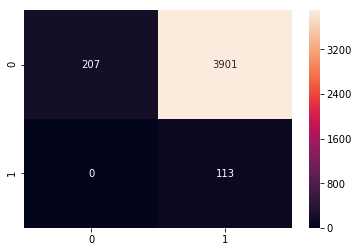

In [135]:
test_data_ab = fram_data[['age', 'bmi', 'diabetes']].dropna()
test_data_abd = fram_data[['age', 'bmi', 'diabp', 'diabetes']].dropna()
pred_ab = model_ab.predict(test_data_ab[['age', 'bmi']])
conf_mat_ab = confusion_matrix(test_data_ab['diabetes'], pred_ab)

sbn.heatmap(conf_mat_ab, annot = True, fmt = '')

## That's. . . not good.

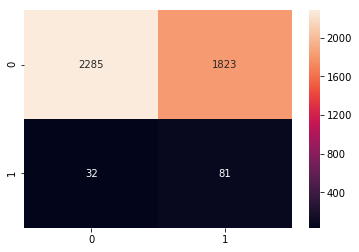

In [136]:
model_ab_none = LogisticRegression(penalty = 'l2', C = 1.0, class_weight = None, 
                              solver = 'liblinear')
ab_data = pima_data[['age', 'bmi', 'diabetes']].dropna()
model_ab_none.fit(ab_data[['age', 'bmi']], ab_data['diabetes'])

pred_ab_none = model_ab_none.predict(test_data_ab[['age', 'bmi']])
conf_mat_ab_none = confusion_matrix(test_data_ab['diabetes'], pred_ab_none)
sbn.heatmap(conf_mat_ab_none, annot = True, fmt = '')

While the models were getting decent scores with weighted recall and balanced accuracy, not looking at the confusion matrix when assessing the models at the start of pima-fram-lab-notebook.ipynb was a bad choice. This model would likely perform better if it were trained on data from a subset of the population it would be used on, I'm not getting reasonable results when applying across populations.

This means that while I have a model that can predict type II diabetes risk in an O'odham population, I don't have a model that can reasonably be rolled out to a wider population without having access to a dataset that's representative of the population at large.

# Conclusions and next steps
I don't have a model that's ready to be rolled out beyond the initial training population (O'odham peoples, in this case). A similar approach of training the model directly on the Framingham dataset might work, but for now, it makes the most sense to table that and come back to it when I'm not trying to start project 4 immediately.